# Training a counterfactually fair CAD model

## Counterfactual Fairness

Attempts to mitigate bias in a model by simply removing sensitive attributes from its training, i.e. fairness by unawareness, often fails due to bias 'leaking' through causal relationships between the sensitive attribute and other features retained in the data. The counterfactual fairness approach introduced by Kusner et al. (2017, in Advances in Neural Information Processing Systems, https://proceedings.neurips.cc/paper_files/paper/2017/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) addresses this limitation by deconvoluting the biased observed variables into a fair set of unbiased latent variables. It allows the model to only learn from information that is independent from the protected attribute, and neutralise both direct and proxy bias pathways.

### Notations and definitions

we adopt the following notations consistent with the Pearlian causal framework used by Kusner et al.:

- $S$ **Protected attribute**: The sensitive variable we wish to be fair toward
- $X$ **Observed features**: The set of features available in the dataset (e.g. Blood Pressure, Cholesterol)
- $U$ **Latent (unobserved) variables**: Unobserved variables that are independent of the protected attribute $A$
- $Y$ **Target**: The outcome we are predicting (e.g. Presence of CAD)
- $Y_{S \leftarrow s}$: The value of $Y$ under a counterfactual intervention where $S$ is set to $s$
- $M = (U, V, F)$ a causal model corresponding to the observed data, where $V \equiv X \cup Y \cup S$, and $F$ is the set of structural equations of the model

**Counterfactual Fairness:** A predictor $\hat{Y}$ is counterfactually fair if, for a specific individual, the probability distribution of the prediction is the same in the actual world as it would be in a counterfactual world where their protected attribute (e.g., Sex) was different.

Formally, for any value $a'$ of the protected attribute $A$:$$P(\hat{Y}_{S \leftarrow s} = y \mid X=x, S=s) = P(\hat{Y}_{S \leftarrow s'} = y \mid X=x, S=s')$$

---


## The experiment

Using the fairness-unaware models trained to predict Cardiovascular Disease in Straw et al. (2024, doi: [10.2196/46936](https://doi.org/10.2196/46936)) as baseline models, we will apply the fairness algorithm proposed by Kusner et al. to train a fair CAD predictor.

### The target bias
While Kusner focus on mitigating bias on tasks where the protected attribute should have no influence on the target outcome (e.g. sex and exam results), the clinical domain brings a new challenge. Indeed, protected attributes such as sex or race often encompass two variables: the clinically relevant biological attribute which can cause a disease to present differently across individuals, and the sociological attribute which has societal factors that can influence healthcare access, physician perception, diagnosis and care. A clinical outcome might be influenced by the former but should remain independent of the latter.

If we aim for fairness based on the high-level sex attribute, we risk removing legitimate clinical signals and degrading diagnostic accuracy. Therefore, our objective in experiment is to make the model counterfactually fair with regards to **sociological sex**.

### Hypothesis

By using counterfactual inference to model latent variables that are independent of the protected attribute, we can build a predictor that satisfies counterfactual fairness (i.e. ensuring that an individual’s predicted risk of CAD remains invariant to their sociological sex), while maintaining clinically acceptable predictive performance and reducing the False Negative Rate (FNR) disparity observed in baseline models.

---

## Causal models

From the feature set observed in the [Heart Disease (CAD) dataset](https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive), using clinical knowledge in the literature and strong assumptions, we create two causal models that we will compare in this experiment:

### Latent variables model

We hypothesise that clinical features in the CAD dataset are manifestations of a patient's **Age- and Sex-independent Physiological Integrity**, which we define as our fair latent variable $U$. It is independent of the protected attributes $S_{bio}$ and $S_{soc}$.

We postulate thatsubjective symptoms and clinician-dependent interpretations are influenced by Sociological Sex ($S_{soc}$). This creates an unfair pathway where the recorded value of a feature is not solely a manifestation of the patient's physiological state, but is also a product of external factors:
- Reporting bias: how a patient describes symptoms like chest pain based on gendered expectations
- Diagnostic bias: how a clinician interprets those symptoms, potentially mislabeling 'atypical' presentations in women

We assume that objective biomarkers such as cholesterol, maximum heart rate, resting blood pressure, fasting blood sugar, and measurements related to the ECG ST slope, are only influenced by the **biological sex** ($S_{bio}$), and are therefore fair pathways for the predictor.

Age is considered as the sole independent variable from $S_{bio}$ and $S_{soc}$.

**Structural equations:**

| Feature | Variable name | Variable type | Model distribution |
|:---|:---|:---|:---|
|Chest Pain Type | $CP$|Categorical|Categorical|
|Exercise Induced Angina | $Ang$|Binary|Bernoulli|
|Resting ECG Result | $ECG$|Categorical|Categorical|
|Max Heart Rate |$MHR$ |Numerical| Normal |
|Fasting Blood Sugar |$FBS$ |Binary|Bernoulli|
|Oldpeak |$ST$ |Numerical| Zero-Inflated Log-Normal |
|ST Slope |$Slope$ |Categorical|Categorical|
|Resting Blood Pressure | $BP$|Numerical| Normal |
|Serum Cholesterol | $Chol$ |Numerical| Log-Normal |
|Age- and Sex-independent Physiological Integrity | $U$|Numerical| Normal |
|Cardiovascular Disease (target outcome) | $Y$|Binary|Bernoulli|

<br>

- $CP = f_{CP}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{CP} + \beta_{CP, U}U + \beta_{CP,S_{soc}}S_{soc} + \beta_{CP,Age}Age))$

- $Ang = f_{Ang}(U, S_{soc}, Age) \sim  \text{Bernoulli}(\text{invlogit}(\alpha_{Ang} + \beta_{Ang, U}U + \beta_{Ang,soc}S_{soc} + \beta_{Ang,Age}Age))$

- $ECG = f_{ECG}(U, S_{soc}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{ECG} + \beta_{ECG, U}U + \beta_{ECG,soc}S_{soc} + \beta_{ECG,Age}Age))$

- $MHR = f_{MHR}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{MHR} + \beta_{MHR,U}U + \beta_{MHR,bio}S_{bio} + \beta_{MHR,Age}Age, \sigma_{MHR})$

- $FBS = f_{FBS}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{FBS} + \beta_{FBS,U}U + \beta_{FBS,bio}S_{bio} + \beta_{FBS,Age}Age))$

- $ST = f_{ST}(U, S_{bio}, Age) \sim \text{ZeroInflatedLogNormal}(\psi_{ST}, \mu_{ST}, \sigma_{ST})$

  - where $\psi_{ST} = \text{invlogit}(\alpha_{\psi} + \beta_{\psi,U}U + \beta_{\psi,bio}S_{bio} + \beta_{\psi,Age}Age)$
  - and $\mu_{ST} = \alpha_{\mu} + \beta_{\mu,U}U + \beta_{\mu,bio}S_{bio}  + \beta_{\mu,Age}Age$

- $Slope =f_{Slope}(U, S_{bio}, Age) \sim \text{Categorical}(\text{softmax}(\alpha_{Slope} + \beta_{Slope, U}U + \beta_{Slope,bio}S_{bio} + \beta_{Slope,Age}Age)) $

- $BP = f_{BP}(U, S_{bio}, Age) \sim \mathcal{N}(\alpha_{BP} + \beta_{BP,U}U + \beta_{BP,bio}S_{bio} + \beta_{BP,Age}Age, \sigma_{BP})$

- $Chol=  f_{Chol}(U, S_{bio}, Age) \sim \text{LogNormal}(\alpha_{Chol} + \beta_{Chol,U}U + \beta_{Chol,bio}S_{bio} + \beta_{Chol,Age}Age, \sigma_{Chol}$

- $Y = f_{Y}(U, S_{bio}, Age) \sim \text{Bernoulli}(\text{invlogit}(\alpha_{Y} + \beta_{Y, U}U + \beta_{Y,bio}S_{bio} + \beta_{Y,Age}Age)) $

- $U \sim \mathcal{N}(0, 1) $

<br>

### Additive error model




## Library imports

In [1]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

Mounted at /content/drive


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm


sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

## Data preparation

In [132]:
heart_disease = pd.read_csv(f'{PROJECT_ROOT}data/heart_disease_cleveland_hungary.csv')

# Remove duplicates and null values, as per Straw et al.

rows_to_drop  = (heart_disease['ST slope'] == 0) | (heart_disease['cholesterol'] == 0) | (heart_disease['resting bp s'] == 0) | (heart_disease.duplicated(keep='first'))
heart_disease.drop(heart_disease[rows_to_drop].index, inplace=True)

heart_disease.rename(columns={'sex':'sex', 'chest pain type':'cp', 'resting bp s':'bp', 'cholesterol':'chol',
                              'fasting blood sugar':'fbs', 'resting ecg':'ecg', 'max heart rate':'mhr', 'exercise angina':'ang',
                              'oldpeak':'st', 'ST slope':'slope', 'target':'cvd'}, inplace=True)

# Clip negative values of st (oldpeak)
heart_disease['st'] = heart_disease['st'].clip(lower=0)

# Z-score for age, bp and mhr
cont_variables = ['bp', 'mhr', 'age']
for var in cont_variables:
  heart_disease[var] = (heart_disease[var] - heart_disease[var].mean()) / heart_disease[var].std()

# Scaling for chol
log_chol = np.log(heart_disease['chol'])
heart_disease['chol_scaled'] = (log_chol - log_chol.mean()) / log_chol.std()

# Indexing cp and slope at 0
heart_disease['cp'] = heart_disease['cp'] - 1
heart_disease['slope'] = heart_disease['slope'] - 1

heart_disease.reset_index(drop=True, inplace=True)
heart_disease.describe()



,age,sex,cp,bp,chol,fbs,ecg,mhr,ang,st,slope,cvd,chol_scaled
count,7.450000e+02,745.000000,745.000000,7.450000e+02,745.000000,745.000000,745.000000,7.450000e+02,745.000000,745.000000,745.000000,745.000000,7.450000e+02
mean,-2.861246e-16,0.755705,2.163758,-1.192186e-18,244.702013,0.166443,0.640268,5.340992e-16,0.385235,0.902953,0.589262,0.476510,2.279459e-15
std,1.000000e+00,0.429957,0.956037,1.000000e+00,59.165249,0.372728,0.838900,1.000000e+00,0.486978,1.072953,0.598288,0.499783,1.000000e+00
min,-2.618103e+00,0.000000,0.000000,-2.372254e+00,85.000000,0.000000,0.000000,-2.903068e+00,0.000000,0.000000,0.000000,0.000000,-4.379780e+00
25%,-7.225862e-01,1.000000,1.000000,-7.521781e-01,208.000000,0.000000,0.000000,-7.432164e-01,0.000000,0.000000,0.000000,0.000000,-5.737713e-01
50%,1.198656e-01,1.000000,2.000000,-1.735796e-01,237.000000,0.000000,0.000000,-9.681997e-03,0.000000,0.500000,1.000000,0.000000,-1.865294e-02
75%,6.463981e-01,1.000000,3.000000,4.050190e-01,275.000000,0.000000,1.000000,8.053562e-01,1.000000,1.500000,1.000000,1.000000,6.138240e-01
max,2.541915e+00,1.000000,3.000000,3.876610e+00,603.000000,1.000000,2.000000,2.516936e+00,1.000000,6.200000,2.000000,1.000000,3.953099e+00


### Relationships in data

We explore the statistical association between the clinical features and the target outcome, sex and age respectively. This will help us parameterise our causal model.

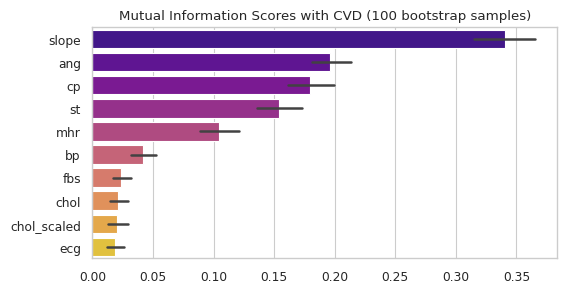

In [140]:
# Mutual information of clinical features with CVD
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['cvd']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', estimator='mean', palette='plasma')
plt.title('Mutual Information Scores with CVD (100 bootstrap samples)')
plt.show()

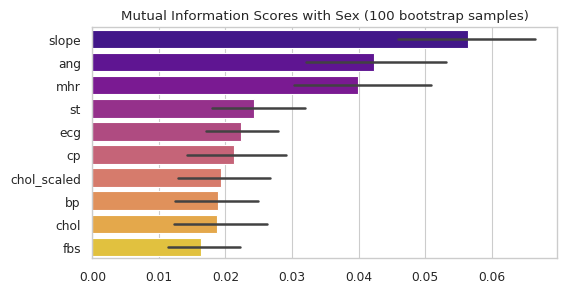

In [141]:
# Mutual information of clinical features with Sex
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['sex']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Sex (100 bootstrap samples)')
plt.show()

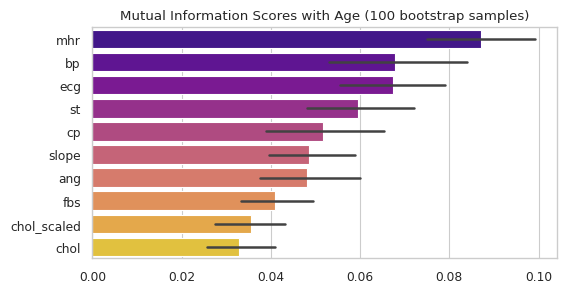

In [139]:
# Mutual information of clinical features with Age
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample
X = heart_disease.drop(['cvd', 'age', 'sex'], axis=1)
y = heart_disease['age']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i)
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores with Age (100 bootstrap samples)')
plt.show()

## Causal inference of a fair variable

### Evidence-based prior selection

In our causal model, each clinical feature $X$ is defined as a function of the target outcome (via the latent variable U), sex and age:
$$X \sim f(\alpha_X + \beta_{X, U}U + \beta_{X,Sex}Sex + \beta_{X,Age}Age)$$

We model the $\beta$ coefficients as normally distributed around 0. The standard variation ($\sigma$) of these coefficients is the 'degree of freedom' granted to the MCMC algorithm to establish a causal link with parent variables. Selecting the correct $\sigma$ involves a critical trade-off:

- **High $\sigma$**: If $\sigma$ is high, the model can capture strong causal relationships. However, if the feature $X$ contains little information about a parent variable ($U$, $Age$ or $Sex$), the sampler will struggle to converge as it searches for a non-existent relationship

- **Low $\sigma$**: If $\sigma$ is too restrictive, we risk "flattening" the model, forcing the $\beta$ coefficients to zero and losing legitimate causal pathways

To move beyond arbitrary parameterisation, we calibrate $\sigma$ based on the result of our Mutual Information analysis:

| Statistical evidence (MI) | Causal signal $P_X → X$ | Prior model parameter ($\sigma$) for $\beta_{X, P_X}$|
| --- | --- | --- |
| < 0.05 | Low | 0.2 |
| 0.05 - 0.15 | Medium | 0.4 |
| > 0.15 | High | 0.75 |

Based on this rule, we choose the following parameters:

| Clinical feature $X$ | $\sigma_{X, U}$ | $\sigma_{X, Sex}$ | $\sigma_{X, Age}$ |
|:---|:---:|:---:|:---:|
| **Slope** | 0.75 | 0.4 | 0.2 |
| **Exercise Angina ($Ang$)** | 0.75 | 0.2 | 0.2 |
| **Chest Pain Type ($CP$)** | 0.75 | 0.2 | 0.4 |
| **Oldpeak ($ST$)** | 0.75 | 0.2 | 0.4 |
| **Max Heart Rate ($MHR$)** | 0.4 | 0.2 | 0.4 |
| **Resting BP ($BP$)** | 0.2 | 0.2 | 0.4 |
| **Resting ECG ($ECG$)** | 0.2 | 0.2 | 0.4 |
| **Fasting Blood Sugar ($FBS$)** | 0.2 | 0.2 | 0.2 |
| **Serum Cholesterol ($Chol$)** | 0.2 | 0.2 | 0.2 |


In [ ]:
with pm.Model() as causal_model:
  # 1. EVIDENCE & PRIORS:
  # Fixed predictors
  age = heart_disease['age'].values
  s_bio = heart_disease['s_bio'].values
  s_soc = heart_disease['s_soc'].values
  N = len(heart_disease)

  # The prior for U, the age- and sex- independent physiological integrity
  # Non-centred parametrisation
  U_raw = pm.Normal('U_raw', mu=0, sigma=1, shape=N)
  sigma_U = pm.HalfNormal('sigma_U', sigma=1)
  U = pm.Deterministic('U', U_raw*sigma_U)

  # 2. LIKELIHOODS: Variables likelihoods
  alpha_cp = pm.Normal('alpha_cp', mu=0, sigma=1, shape=4)
  beta_U_cp = pm.math.concatenate([[0],pm.Normal('beta_U_cp', mu=0, sigma=.25, shape=3)])
  beta_soc_cp = pm.math.concatenate([[0],pm.Normal('beta_soc_cp', mu=0, sigma=.25, shape=3)])
  beta_age_cp = pm.math.concatenate([[0],pm.Normal('beta_age_cp', mu=0, sigma=.25, shape=3)])
  cp = pm.Categorical('cp',
            logit_p=alpha_cp + beta_U_cp*U[:,None] + beta_soc_cp*s_soc[:,None] + beta_age_cp*age[:,None],
            observed=heart_disease['cp'])

  alpha_ang = pm.Normal('alpha_ang', mu=0, sigma=1)
  beta_U_ang = pm.Normal('beta_U_ang', mu=0, sigma=.25)
  beta_soc_ang = pm.Normal('beta_soc_ang', mu=0, sigma=.25)
  beta_age_ang = pm.Normal('beta_age_ang', mu=0, sigma=.25)
  ang = pm.Bernoulli('ang',
            logit_p=alpha_ang + beta_U_ang*U + beta_soc_ang*s_soc + beta_age_ang*age,
            observed=heart_disease['ang'])

  alpha_ecg = pm.Normal('alpha_ecg', mu=0, sigma=1, shape=3)
  beta_U_ecg = pm.math.concatenate([[0],pm.Normal('beta_U_ecg', mu=0, sigma=.4, shape=2)])
  beta_soc_ecg = pm.math.concatenate([[0],pm.Normal('beta_soc_ecg', mu=0, sigma=.4, shape=2)])
  beta_age_ecg = pm.math.concatenate([[0],pm.Normal('beta_age_ecg', mu=0, sigma=.4, shape=2)])
  ecg = pm.Categorical('ecg',
            logit_p=alpha_ecg + beta_U_ecg*U[:,None] + beta_soc_ecg*s_soc[:,None] + beta_age_ecg*age[:,None],
            observed=heart_disease['ecg'])

  alpha_mhr = pm.Normal('alpha_mhr', mu=0, sigma=1)
  beta_U_mhr = pm.Normal('beta_U_mhr', mu=0, sigma=.25)
  beta_bio_mhr = pm.Normal('beta_bio_mhr', mu=0, sigma=.25)
  beta_age_mhr = pm.Normal('beta_age_mhr', mu=0, sigma=.25)
  sigma_mhr = pm.HalfNormal('sigma_mhr', sigma=1)
  mhr = pm.Normal('mhr',
            mu=alpha_mhr + beta_U_mhr*U + beta_bio_mhr*s_bio + beta_age_mhr*age,
            sigma=sigma_mhr,
            observed=heart_disease['mhr'])

  alpha_fbs = pm.Normal('alpha_fbs', mu=0, sigma=1)
  beta_U_fbs = pm.Normal('beta_U_fbs', mu=0, sigma=.25)
  beta_bio_fbs = pm.Normal('beta_bio_fbs', mu=0, sigma=.25)
  beta_age_fbs = pm.Normal('beta_age_fbs', mu=0, sigma=.25)
  fbs = pm.Bernoulli('fbs',
            logit_p=alpha_fbs + beta_U_fbs*U + beta_bio_fbs*s_bio + beta_age_fbs*age,
            observed=heart_disease['fbs'])

  alpha_slope = pm.Normal('alpha_slope', mu=0, sigma=1, shape=3)
  beta_U_slope = pm.math.concatenate([[0],pm.Normal('beta_U_slope', mu=0, sigma=.25, shape=2)])
  beta_bio_slope = pm.math.concatenate([[0],pm.Normal('beta_bio_slope', mu=0, sigma=.25, shape=2)])
  beta_age_slope = pm.math.concatenate([[0],pm.Normal('beta_age_slope', mu=0, sigma=.25, shape=2)])
  slope = pm.Categorical('slope',
            logit_p=alpha_slope + beta_U_slope*U[:,None] + beta_bio_slope*s_bio[:,None] + beta_age_slope*age[:,None],
            observed=heart_disease['slope'])

  alpha_bp = pm.Normal('alpha_bp', mu=0, sigma=1)
  beta_U_bp = pm.Normal('beta_U_bp', mu=0, sigma=.25)
  beta_bio_bp = pm.Normal('beta_bio_bp', mu=0, sigma=.25)
  beta_age_bp = pm.Normal('beta_age_bp', mu=0, sigma=.25)
  sigma_bp = pm.HalfNormal('sigma_bp', sigma=1)
  bp = pm.Normal('bp',
            mu=alpha_bp + beta_U_bp*U + beta_bio_bp*s_bio + beta_age_bp*age,
            sigma=sigma_bp,
            observed=heart_disease['bp'])

  alpha_chol = pm.Normal('alpha_chol', mu=0, sigma=1)
  beta_U_chol = pm.Normal('beta_U_chol', mu=0, sigma=.25)
  beta_bio_chol = pm.Normal('beta_bio_chol', mu=0, sigma=.25)
  beta_age_chol = pm.Normal('beta_age_chol', mu=0, sigma=.25)
  sigma_chol = pm.HalfNormal('sigma_chol', sigma=1)
  chol = pm.Normal('chol',
            mu=alpha_chol + beta_U_chol*U + beta_bio_chol*s_bio + beta_age_chol*age,
            sigma=sigma_chol,
            observed=heart_disease['chol_scaled'])

  alpha_cvd = pm.Normal('alpha_cvd', mu=0, sigma=1)
  beta_bio_cvd = pm.Normal('beta_bio_cvd', mu=0, sigma=.25)
  beta_age_cvd = pm.Normal('beta_age_cvd', mu=0, sigma=.25)
  cvd = pm.Bernoulli('cvd',
            logit_p=alpha_cvd - U + beta_bio_cvd*s_bio + beta_age_cvd*age, #we force U to be invertly related to CVD
            observed=heart_disease['cvd'])

  # CUSTOM DIST. for Oldpeak (ST): Zero-inflated Log-normal
  # Probability of being exactly zero
  alpha_zero_st = pm.Normal('alpha_zero_st', mu=0, sigma=.5)
  beta_U_zero_st = pm.Normal('beta_U_zero_st', mu=0, sigma=.25)
  beta_bio_zero_st = pm.Normal('beta_bio_zero_st', mu=0, sigma=.25)
  beta_age_zero_st = pm.Normal('beta_age_zero_st', mu=0, sigma=.25)
  psi_st = pm.math.invlogit(alpha_zero_st + beta_U_zero_st*U + beta_bio_zero_st*s_bio + beta_age_zero_st*age)

  # Log-normal parameters
  non_zero_st = heart_disease['st'][heart_disease['st'] > 0]
  alpha_init_st = np.log(non_zero_st.mean()) if len(non_zero_st) > 0 else 0
  alpha_st = pm.Normal('alpha_st', mu=0, sigma=1, initval=alpha_init_st)
  beta_U_st = pm.Normal('beta_U_st', mu=0, sigma=.25)
  beta_U_bio_st = pm.Normal('beta_U_bio_st', mu=0, sigma=.25)
  beta_U_age_st = pm.Normal('beta_U_age_st', mu=0, sigma=.25)
  sigma_st = pm.HalfNormal('sigma_st', sigma=1)
  mu_st = alpha_st + beta_U_st*U + beta_U_bio_st*s_bio + beta_U_age_st*age
  sigma_st = sigma_st

  # Probability function for the custom distribution
  def zero_inflated_lognormal(value, psi, mu, sigma):
    # Log-probability for the zero cases
    logp_zero = pm.math.log(psi)

    # Log-probability for the non-zero cases
    safe_value = pm.math.switch(pm.math.eq(value, 0), 1.0, value)
    logp_nonzero = pm.math.log(1 - psi) + pm.logp(pm.LogNormal.dist(mu=mu, sigma=sigma), safe_value)

    return pm.math.switch(pm.math.eq(value, 0), logp_zero, logp_nonzero)

  # Define the custom distribution
  st = pm.CustomDist('st',
                     psi_st, mu_st, sigma_st,
                     logp=zero_inflated_lognormal,
                     observed=heart_disease['st'])


  # 3. INFERENCE of U with MCMC
  posterior_samples = pm.sample(target_accept=0.95)




In [ ]:
import os
save_path = f'{PROJECT_ROOT}/counterfactual-fairness/results'
os.makedirs(save_path, exist_ok=True)

posterior_samples.to_netcdf(f'{save_path}/causal_model_posterior.nc')
print('Posterior samples saved')


### Causal parameters extraction

In [ ]:
import arviz as az

posterior = az.from_netcdf(f'{PROJECT_ROOT}/counterfactual-fairness/results/causal_model_posterior.nc')

# extract the causal model parameters we will use to compute the counterfactuals
cf_params = az.summary(posterior, var_names=['alpha_cp','beta_U_cp','beta_soc_cp','beta_age_cp',
                                           'alpha_ang','beta_U_ang','beta_soc_ang','beta_age_ang',
                                           'alpha_ecg','beta_U_ecg','beta_soc_ecg','beta_age_ecg'])\
                                           .reset_index(names='raw_param')[['raw_param','mean']]

cf_params['param'] = cf_params['raw_param'].str.split('[').str[0].str.strip()
cf_params['logit_index'] = cf_params['raw_param'].str.split('[').str[1].str[0]
cf_params['logit_index'] = cf_params['logit_index'].fillna(0).astype(int)
cf_params.drop('raw_param', axis=1, inplace=True)

alpha_cp = cf_params[cf_params['param'] == 'alpha_cp'].sort_values('logit_index')['mean'].values
beta_U_cp = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_U_cp'].sort_values('logit_index')['mean'].values])
beta_soc_cp = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_soc_cp'].sort_values('logit_index')['mean'].values])
beta_age_cp = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_age_cp'].sort_values('logit_index')['mean'].values])
alpha_ecg = cf_params[cf_params['param'] == 'alpha_ecg'].sort_values('logit_index')['mean'].values
beta_U_ecg = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_U_ecg'].sort_values('logit_index')['mean'].values])
beta_soc_ecg = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_soc_ecg'].sort_values('logit_index')['mean'].values])
beta_age_ecg = np.concatenate([[0],cf_params[cf_params['param'] == 'beta_age_ecg'].sort_values('logit_index')['mean'].values])
alpha_ang = cf_params[cf_params['param'] == 'alpha_ang'].sort_values('logit_index')['mean'].values
beta_U_ang = cf_params[cf_params['param'] == 'beta_U_ang'].sort_values('logit_index')['mean'].values
beta_soc_ang = cf_params[cf_params['param'] == 'beta_soc_ang'].sort_values('logit_index')['mean'].values
beta_age_ang = cf_params[cf_params['param'] == 'beta_age_ang'].sort_values('logit_index')['mean'].values


### Model validation

## Augmented dataset

In [ ]:
# AUGMENTED DATASET

# Define the number of samples (m) taken for each individual from the infered posterior
m = 20

# Extract the U samples from the posterior
# posterior_samples.posterior['U'].to_dataframe().reset_index()
samples = az.extract(posterior, var_names=['U'],
                                          combined=True, num_samples=20).to_dataframe().reset_index()

# Merge samples with original dataset
heart_disease_reset = heart_disease.reset_index(drop=True)
aug_heart_disease = heart_disease_reset.merge(samples, left_index=True, right_on='U_dim_0')

# Fair dataset:
# Keep only sex-independent variables (age), latent fair variable U, and outcome CVD
fair_heart_disease = aug_heart_disease[['U_dim_0','age','U','s_bio','cvd']]

## Function library

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
 recall_score, roc_auc_score
from scipy.stats import sem, t

def train_random_forest(X_train, y_train, X_test, y_test):
  '''
    Trains a sklearn RandomForestClassifier on the given training data,\
     optimised hyperparameters with 3-fold GridSearchCV

     Inputs:
       X_train: training features
       y_train: training labels
       X_test: test features
       y_test: test labels

     Outputs:
       rf: trained RandomForestClassifier
       y_pred: predicted labels
       y_pred_proba: predicted probabilities
  '''
  param_grid = {
    "n_estimators": [100],
    "max_depth": [5, 10, 20, None],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
  }

  #create the RF classifier
  rf = RandomForestClassifier()

  #create the grid search
  rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=10, scoring='roc_auc',
                               cv=3, n_jobs=-1, random_state=42)

  #fit the grid search
  rf_search.fit(X_train, y_train)
  y_pred = rf_search.predict(X_test)
  y_pred_proba = rf_search.predict_proba(X_test)[:,1]

  return [rf_search, y_pred, y_pred_proba]

def get_perf_metrics(y_true, y_pred, y_pred_proba):
  '''
    Calculates the performance metrics for a given set of predictions.

    Inputs
      y_true: true labels
      y_pred: predicted labels
      y_pred_proba: predicted probabilities

    Outputs
      accuracy: accuracy score
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
      FNR: False Negative Rate
      FPR: False Positive Rate
      tn: True Negatives
      fp: False Positives
      fn: False Negatives
      tp: True Positives
  '''
  accuracy = accuracy_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred_proba)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  FNR = fn / (fn + tp)
  FPR = fp / (fp + tn)

  return [accuracy, roc_auc, FNR, FPR, tn, fp, fn, tp]

def get_95_ci(data):
  '''
    Calculates the 95% confidence interval for a given set of data.

    Inputs
      data: data as a Pandas Series

    Outputs
      interval: Array of the lower and upper bounds of the confidence interval
  '''
  n = len(data)
  mean = data.mean()
  std_err = sem(data)
  interval = t.interval(0.95, n - 1, loc=mean, scale=std_err)
  return interval



## Predictive models training and evaluation

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import barnard_exact

# baseline features and target class

X = heart_disease.drop(['cvd', 'chol','s_soc'], axis=1).rename(columns={'s_bio':'sex'})
y = heart_disease['cvd']

# Bootstrapping approach with N_RUNS runs and a 70/30 split for training and test
N_RUNS = 1

sss = StratifiedShuffleSplit(n_splits=N_RUNS, test_size=0.3, random_state=42)

perf_metrics = []

for i, (train_index, test_index) in tqdm(enumerate(sss.split(X, y)), total=N_RUNS, desc="Running simulations"):

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Create the equivalent fair training and test sets
  fair_X_train = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(train_index),
                                        ['U','age']]
  fair_X_test = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index),
                                       ['U','age']]
  fair_y_train = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(train_index), 'cvd']
  fair_y_test = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index), 'cvd']

  # Train the baseline and fair models
  rf, y_pred, y_pred_proba = train_random_forest(X_train, y_train, X_test, y_test)
  fair_rf, fair_y_pred, fair_y_pred_proba = train_random_forest(fair_X_train, fair_y_train, fair_X_test, fair_y_test)

  #measure global performance metrics
  accuracy, roc_auc, FNR, FPR,*_ = get_perf_metrics(y_test, y_pred, y_pred_proba)
  fair_accuracy, fair_roc_auc, fair_FNR, fair_FPR,*_ = get_perf_metrics(fair_y_test, fair_y_pred, fair_y_pred_proba)


  # COUNTERFACTUAL TEST
  # X_test_cf: flip s_soc, and replace ecg, ang, cpt with counterfactual values ,
  X_test_cf = X_test.copy()
  # X_test_cf['sex'] = 1 - X_test_cf['sex']

  # Compute the mean value of U for each individual in the test set
  mean_U = fair_heart_disease.groupby('U_dim_0')['U'].mean()
  X_test_cf['U'] = X_test_cf.index.map(lambda x: mean_U[x])

  #ECG
  ecg_logits = [alpha + beta_U*X_test_cf['U'] + beta_soc*X_test_cf['sex'] + beta_age*X_test_cf['age']\
                for alpha, beta_U, beta_soc, beta_age in zip(alpha_ecg, beta_U_ecg, beta_soc_ecg, beta_age_ecg)]
  ecg_logits = np.transpose(np.array(ecg_logits))
  print('Mean ECG logits: ', ecg_logits.mean(axis=0))
  ecg_probs = np.exp(ecg_logits) / np.sum(np.exp(ecg_logits), axis=1, keepdims=True)
  X_test_cf['new_ecg'] = np.argmax(ecg_probs, axis=1)

  #CP
  cp_logits = [alpha + beta_U*X_test_cf['U'] + beta_soc*X_test_cf['sex'] + beta_age*X_test_cf['age']\
                for alpha, beta_U, beta_soc, beta_age in zip(alpha_cp, beta_U_cp, beta_soc_cp, beta_age_cp)]
  cp_logits = np.transpose(np.array(cp_logits))
  print('Mean CP logits: ', cp_logits.mean(axis=0))
  cp_probs = np.exp(cp_logits) / np.sum(np.exp(cp_logits), axis=1, keepdims=True)
  X_test_cf['new_cp'] = np.argmax(cp_probs, axis=1)

  #ANG
  ang_logit = alpha_ang[0] + beta_U_ang[0]*X_test_cf['U'] + beta_soc_ang[0]*X_test['sex'] + beta_age_ang[0]*X_test_cf['age']
  ang_prob = 1 / (1 + np.exp(-ang_logit))
  X_test_cf['new_ang'] = (ang_prob > 0.5).astype(int)

  print(X_test_cf[['ang','new_ang','ecg','new_ecg','cp','new_cp']].head(20).to_markdown(tablefmt='simple', index=False))


  # STRATIFIED PERFORMANCE AUDIT
  baseline_audit_df = X_test.copy()
  baseline_audit_df['y_true'] = y_test
  baseline_audit_df['y_pred'] = y_pred
  baseline_audit_df['y_pred_proba'] = y_pred_proba
  baseline_male_df = baseline_audit_df[baseline_audit_df['sex'] == 1]
  baseline_female_df = baseline_audit_df[baseline_audit_df['sex'] == 0]

  fair_audit_df = fair_heart_disease.loc[fair_heart_disease['U_dim_0'].isin(test_index),
                                       ['U','age','s_bio']].copy()
  fair_audit_df['y_true'] = fair_y_test
  fair_audit_df['y_pred'] = fair_y_pred
  fair_audit_df['y_pred_proba'] = fair_y_pred_proba
  fair_male_df = fair_audit_df[fair_audit_df['s_bio'] == 1]
  fair_female_df = fair_audit_df[fair_audit_df['s_bio'] == 0]

  accuracy_m, roc_auc_m, FNR_m, FPR_m, tn_m, fp_m, fn_m, tp_m = get_perf_metrics(
      baseline_male_df['y_true'],
      baseline_male_df['y_pred'],
      baseline_male_df['y_pred_proba'])

  accuracy_f, roc_auc_f, FNR_f, FPR_f, tn_f, fp_f, fn_f, tp_f = get_perf_metrics(
      baseline_female_df['y_true'],
      baseline_female_df['y_pred'],
      baseline_female_df['y_pred_proba'])

  fair_accuracy_m, fair_roc_auc_m, fair_FNR_m, fair_FPR_m, *_ = get_perf_metrics(
      fair_male_df['y_true'],
      fair_male_df['y_pred'],
      fair_male_df['y_pred_proba'])

  fair_accuracy_f, fair_roc_auc_f, fair_FNR_f, fair_FPR_f, *_ = get_perf_metrics(
      fair_female_df['y_true'],
      fair_female_df['y_pred'],
      fair_female_df['y_pred_proba'])





  perf_metrics.append({
      'run': i,
      'accuracy': accuracy,
      'roc_auc': roc_auc,
      'FNR': FNR,
      'FPR': FPR,
      'fair_accuracy': fair_accuracy,
      'fair_roc_auc': fair_roc_auc,
      'fair_FNR': fair_FNR,
      'fair_FPR': fair_FPR,
      'accuracy_m': accuracy_m,
      'roc_auc_m': roc_auc_m,
      'FNR_m': FNR_m,
      'FPR_m': FPR_m,
      'accuracy_diff': accuracy_m - accuracy_f,
      'roc_auc_diff': roc_auc_m - roc_auc_f,
      'FNR_diff': FNR_m - FNR_f,
      'FPR_diff': FPR_m - FPR_f,
      'fair_accuracy_diff': fair_accuracy_m - fair_accuracy_f,
      'fair_roc_auc_diff': fair_roc_auc_m - fair_roc_auc_f,
      'fair_FNR_diff': fair_FNR_m - fair_FNR_f,
      'fair_FPR_diff': fair_FPR_m - fair_FPR_f
  })


Running simulations: 100%|██████████| 1/1 [00:27<00:00, 27.93s/it]

Mean ECG logits:  [ 0.768      -0.55185246 -0.2011201 ]
Mean CP logits:  [-1.022      -0.19828648  0.3028031   0.89021442]
  ang    new_ang    ecg    new_ecg    cp    new_cp
-----  ---------  -----  ---------  ----  --------
    0          0      0          0     1         1
    0          0      2          0     2         1
    1          1      0          0     3         3
    0          0      1          0     3         2
    0          0      1          0     1         1
    0          0      0          0     1         3
    1          1      2          0     3         3
    0          0      1          0     1         1
    1          1      0          0     2         3
    0          0      0          0     3         3
    1          1      1          0     3         3
    0          0      1          0     3         1
    1          1      1          0     3         3
    1          0      0          0     0         3
    0          0      0          0     3         1
    1     

In [ ]:
import os
save_path = f'{PROJECT_ROOT}/counterfactual-fairness/results'
os.makedirs(save_path, exist_ok=True)

perf_metrics_df = pd.DataFrame(perf_metrics)
perf_metrics_df.to_csv(f'{save_path}/perf_metrics_{N_RUNS}_runs.csv')

In [ ]:
# perf_metrics_df = pd.read_csv(f'{PROJECT_ROOT}/counterfactual-fairness/results/perf_metrics_{N_RUNS}_runs.csv')


# BASELINE PERFORMANCE
accuracy_ci = get_95_ci(perf_metrics_df['accuracy'])
roc_auc_ci = get_95_ci(perf_metrics_df['roc_auc'])
fnr_ci = get_95_ci(perf_metrics_df['FNR'])
fpr_ci = get_95_ci(perf_metrics_df['FPR'])

# FAIR PERFORMANCE
fair_accuracy_ci = get_95_ci(perf_metrics_df['fair_accuracy'])
fair_roc_auc_ci = get_95_ci(perf_metrics_df['fair_roc_auc'])
fair_fnr_ci = get_95_ci(perf_metrics_df['fair_FNR'])
fair_fpr_ci = get_95_ci(perf_metrics_df['fair_FPR'])

perf_summary = pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Accuracy': [perf_metrics_df['accuracy'].mean(),
                 perf_metrics_df['fair_accuracy'].mean()],
    'Acc. 95% CI': [f'{round(accuracy_ci[0], 3)}-{round(accuracy_ci[1], 3)}',
                    f'{round(accuracy_ci[0], 3)}-{round(fair_accuracy_ci[1], 3)}'],
    'ROC AUC': [perf_metrics_df['roc_auc'].mean(),
                perf_metrics_df['fair_roc_auc'].mean()],
    'ROC AUC 95% CI': [f'{round(roc_auc_ci[0], 3)}-{round(roc_auc_ci[1], 3)}',
                       f'{round(roc_auc_ci[0], 3)}-{round(fair_roc_auc_ci[1], 3)}'],
    'FNR': [perf_metrics_df['FNR'].mean(),
             perf_metrics_df['fair_FNR'].mean()],
    'FNR 95% CI': [f'{round(fnr_ci[0], 3)}-{round(fnr_ci[1], 3)}',
                    f'{round(fair_fnr_ci[0], 3)}-{round(fair_fnr_ci[1], 3)}'],
    'FPR': [perf_metrics_df['FPR'].mean(),
             perf_metrics_df['fair_FPR'].mean()],
    'FPR 95% CI': [f'{round(fpr_ci[0], 3)}-{round(fpr_ci[1], 3)}',
                    f'{round(fair_fpr_ci[0], 3)}-{round(fair_fpr_ci[1], 3)}']
})

print(perf_summary.to_markdown(tablefmt='simple', index=False, numalign="right"))


Model       Accuracy  Acc. 95% CI      ROC AUC  ROC AUC 95% CI         FNR  FNR 95% CI         FPR  FPR 95% CI
--------  ----------  -------------  ---------  ----------------  --------  ------------  --------  ------------
Baseline    0.870982  0.862-0.88      0.929236  0.921-0.938        0.13271  0.112-0.153   0.125641  0.112-0.139
Fair        0.878661  0.862-0.888     0.949142  0.921-0.955       0.120374  0.11-0.131    0.122222  0.107-0.138


In [ ]:
from scipy.stats import ttest_rel

# Statistical significance of the difference in FNR disparity
fnr_fair_ttest = ttest_rel(perf_metrics_df['fair_FNR_diff'],
                           perf_metrics_df['FNR_diff'],
                           alternative='greater')
print("FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS")
print(f"Average FNR Disparity in the baseline model:\
 {perf_metrics_df['FNR_diff'].mean():.4f}")
print(f"Std Dev FNR Disparity in the baseline model:\
 {perf_metrics_df['FNR_diff'].std():.4f}")
print('-'*20)
print(f"Average FNR Disparity in the fair model:\
 {perf_metrics_df['fair_FNR_diff'].mean():.4f}")
print(f"Std Dev FNR Disparity in the fair model:\
 {perf_metrics_df['fair_FNR_diff'].std():.4f}")
print('-'*20)
print(f"Paired T-Statistic (t): {fnr_fair_ttest.statistic:.4f}")
print(f"P-value: {fnr_fair_ttest.pvalue:.6f}")


FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS
Average FNR Disparity in the baseline model: -0.1223
Std Dev FNR Disparity in the baseline model: 0.0903
--------------------
Average FNR Disparity in the fair model: 0.0401
Std Dev FNR Disparity in the fair model: 0.0436
--------------------
Paired T-Statistic (t): 7.3505
P-value: 0.000022
